In [1]:
import gzip
import json
import pandas as pd
import numpy as np
from os.path import join, isfile
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
def get_json(fname, fpath='../results/arango/'):
    fname = join(fpath, fname)
    with open(fname, 'r') as fp:
        data = json.load(fp)
    return data

def get_json_fnames(sourcepath='../../wos_paper/wos_db_benchmark/benchmarking/'):
    only_json = [f for f in listdir(sourcepath) if 
                     isfile(join(sourcepath, f)) 
                     and f[-4:] == 'json']
    return sorted(only_json)

def get_content(sql_list, fpath, how='sql'):
    report = []
    if how == 'sql':
        limit_tokens = 2
    elif how == 'arango':
        limit_tokens = 3
    else:
        limit_tokens = 3
    for f in sql_list:
        coded = f.split('_')
        limit = -1 if len(coded) < limit_tokens else int(coded[-1].split('.')[0])
        content = get_json(f, fpath)
        report += [(coded[0], limit, f, content)]
    return report

def get_time_stat_arango(reports):
    times = [(*item[:-1], [sum(x.values()) for x in item[-1]]) for item in reports]
    times_stat = [(*item[:-1], np.mean(item[-1]), np.std(item[-1])) for item in times]

In [25]:
json_items = get_json_fnames('../results/arango/')
# [(fn.split('_')[0][-1], fn) for fn in only_json]

In [26]:
reports = get_content(json_items, '../results/arango/', 'arango')

In [28]:
times = [(*item[:-1], [sum(x.values()) for x in item[-1]]) for item in reports]

In [29]:
times_stat = [(*item[:-1], np.mean(item[-1]), np.std(item[-1])) for item in times]

In [5]:
baselines = [x for x in json_items if len(x[1].split('_')) < 3]
dfb = pd.DataFrame(baselines, columns=['q', 'fname'])
dfb['json'] = dfb.fname.apply(lambda x: get_json(x))
dfb['mean'] = dfb.json.apply(lambda x: 
    np.mean([float(y['executing']) for y in x]))
dfb = dfb.sort_values('q')
bdict = dict(dfb[['q', 'mean']].values)

In [6]:
arrs = [x for x in json_items if len(x[1].split('_')) > 3]
df_main = pd.DataFrame(arrs, columns=['q', 'fname'])
df_main['json'] = df_main.fname.apply(lambda x: get_json(x))
df_main['lim'] = df_main.fname.apply(lambda x: 
            float(x.split('_')[-1].split('.')[0]))
df_main['val'] = df_main.json.apply(lambda x: 
                    [y['executing'] for y in x])
df_main = df_main.explode('val')
df_main.val = df_main.val.astype(np.float)

In [10]:
dfr = df_main.sort_values(['q', 'lim'])[['q', 'lim', 'val']]
dfr = dfr.rename(columns={'val': 'sec'})
dfr.head()

,q,lim,sec
12,1,5.0,0.000396
12,1,5.0,0.000280
12,1,5.0,0.000226
17,1,10.0,0.000431
17,1,10.0,0.000393


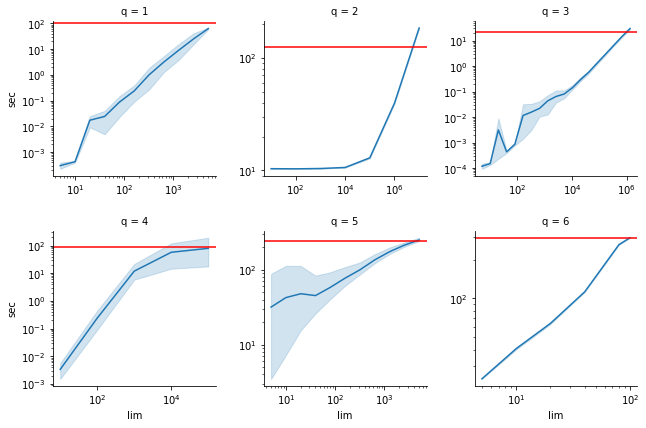

In [14]:
g = sns.FacetGrid(dfr, col='q', sharex=False, sharey=False, 
                  col_wrap=3, margin_titles=True)
g.map(sns.lineplot, 'lim', 'sec').set(yscale='log').set(xscale='log')
for j, ax in enumerate(g.axes):
    ax.axhline(bdict[str(j+1)], c='r')
plt.savefig('../figs/query_times.pdf')